<a href="https://colab.research.google.com/github/RonnyGuevara/Digital-image-processing/blob/main/TP_FINAL/TP_FINAL_PDI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

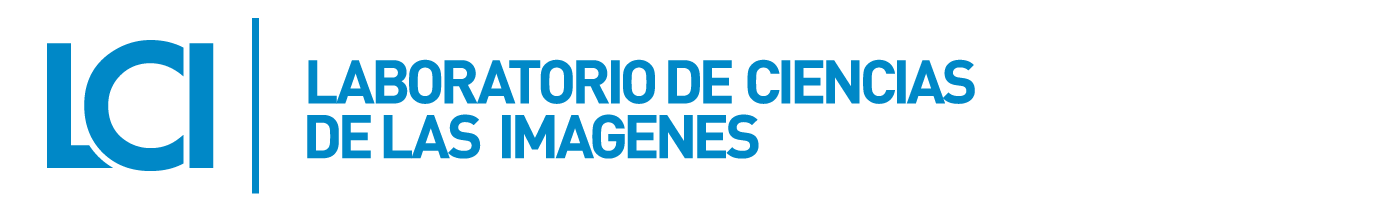

#**Universidad Nacional del Sur**
#Trabajo Final de Cátedra
##Tópicos Avanzados en Procesamiento de Imágenes
##Tema: Detección temprana de Roya(Uromyces appendiculatus) y mancha angular en hojas de frejol aplicando una red neuronal convolucional

##Presentado por: Ronny Guevara
###Bahía Blanca - Argentina

## Resumen
En este trabajo se presenta la aplicación de redes neuronales convolucionales para identificar la Roya o chahuixtle (Uromyces appendiculatus) y mancha angular en hojas de frejol. Para ello, se utiliza un conjunto de datos de imágenes de frijoles tomadas en campo, posterior, los datos fueron anotados por expertos del Instituto Nacional de Investigación de Recursos de Cultivos (NaCRRI) en Uganda y recopilados por el laboratorio de investigación Makerere AI.
El conjunto de datos contiene 1295 imágenes de 500 * 500 pixeles con 3 canales de información (RGB), las mismas están divididas en 128 imágenes para 'test', 1034 imágenes para 'train' y 133 imágenes para 'validation'.


## Objetivo General
Desarrollar un aplicativo que permita detectar enfermedades en las plantas de frijol implementando una red neuronal convolucional
## Objetivos Específicos
*   Desarrollar clasificadores que dado los atributos de un dataset permita predecir la benignidad o malignidad de un tumor
*   Mediante la selección de datos proponer un clasificador supervisados y entrenados
*   Visualización de resultados

###Introducción
Las plagas y enfermedades bacterianas de las plantas afectan a los cultivos alimentarios, lo que causa pérdidas significativas a los agricultores y amenaza la seguridad alimentaria (FAO)
Un estudio realizado por la vanguardia informa que el 40% de los cultivos alimentarios se pierden cada año por los efectos de las plagas, enfermedades y malas hierbas, es por ello, que se ve la necesidad de prevenir la pérdida del cultivo mediante la detección oportuna de enfermedades. Sin embargo, debido a que cada planta tiene enfermedades distintas y existe carencia de datos suficientes, se trabajara con enfermedades del frijol.


Es importante conocer algunas conceptualizaciones: 

*   Red Neuronal Convolucional: Las Redes neuronales convolucionales son  un tipo de redes neuronales artificiales  donde las «neuronas»  corresponden a campos receptivos de una manera muy similar a las neuronas en la corteza visual primaria (V1) de un cerebro biológico.  Este tipo de red es una variación de un perceptrón multicapa, sin embargo, debido a que su aplicación es realizada en matrices bidimensionales, son muy efectivas para tareas de visión artificial, como en la clasificación y segmentación de imágenes, entre otras aplicaciones.
*   Uromyces appendiculatus: Es una hongo que afecta oda la parte aérea de la planta aunque comúnmente se localiza en hojas y eventualmente en vainas. En las hojas se observan unas puntuaciones o pústulas de color rojizo o marrón, aisladas o reunidas en tejido muerto de gran tamaño. Estas pústulas contienen un polvo abundante correspondiente a las fluctuaciones del hongo, que confieren a las hojas un aspecto de “herrumbre”.
Es un parásito obligado, cuyo ciclo se completa plenamente en la planta huésped. Las formas más frecuentes observadas son esporas de verano o vegetativas, de color ladrillo, denominadas uredosporas y esporas de inviernos o latentes, oscuras denominadas teliospora.
 Más información: https://www.sinavimo.gob.ar/plaga/uromyces-appendiculatus
*   Mancha angular: causada por el hongo Pseudocercospora griseola afecta el rendimiento y la calidad de la semilla. En Argentina esta enfermedad fue convirtiéndose gradualmente en una limitante del cultivo, por lo que su manejo es un aspecto importante a tener en cuenta en la producción de poroto.
Más información: http://www.scielo.org.ar/scielo.php?script=sci_arttext&pid=S1851-30182017000100006#:~:text=La%20mancha%20angular%20del%20poroto,en%20la%20producci%C3%B3n%20de%20poroto.

##Desarrollo

###1. Revisión del conjunto de datos
La primera parte consiste en leer los conjuntos de imagenes, crear las respectivas etiquetas

In [1]:
#Lectura de librerías
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
import io
import random

El conjunto de imágenes se encuentra cargado en el Drive por lo que es necesario hacer el respectivo llamado

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#Asignamos la ruta de llamado para cada variable
normal_training_route = "/content/drive/MyDrive/Colab Notebooks/chest_xray/test/NORMAL"
pneumonia_training_route = "/content/drive/MyDrive/Colab Notebooks/chest_xray/test/PNEUMONIA"

###Creación de funciones

####1. Función image_processing
Las imágenes tienen el siguiente tratamiento: 

*   La imagen es leída mediante la librería CV2
*   Se aplica un filtro de conversión pasando del espacio RGB al espacio de escala de grises
*   Reajuste del tamaño de la imagen a 50 * 50 pixeles
*   Normalización de la imagen

In [4]:
def image_processing(image):
  tupla = []
  img_size = 50
  for img in os.listdir(image):
    img = cv2.imread(os.path.join(image, img))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img_norm=img_gray.astype(np.float64)/255
    img_gray_resize = cv2.resize(img_norm,(img_size,img_size))
    tupla.append([img_gray_resize])
  return(tupla)

####2. Función image_info
Retorna información de la imagen:

*   Tipo de dato
*   Dimensiones

In [5]:
def image_info(image):
  normal = np.array(np.squeeze(image))
  print('This image is', normal.dtype)
  print('with dimensions', normal.shape)

####2. Función etiqueta
Retorna 2 tuplas cada una con el tamaño del total de imagenes para casos con y sin neumonia

In [26]:
def etiqueta(normal, neumonia):
  normal = normal.shape
  neumonia = neumonia.shape
  etiqueta = np.repeat((0, normal[0]))
  etiqueta1 = np.repeat((0, neumonia[0]))

  return(etiqueta, etiqueta1)

In [28]:
#Lectura de las imagenes de rayos X sin neumonia
normal = image_processing(normal_training_route)
image_info(normal)

This image is float64
with dimensions (234, 50, 50)


In [22]:
#Lectura de las imagenes de rayos X con neumonia
neumonia = image_processing(pneumonia_training_route)
image_info(neumonia)

This image is float64
with dimensions (390, 50, 50)


In [29]:
etiquetas_normal = np.repeat(0, 234)
print(len(etiquetas_normal))
etiquetas_neumonia = np.repeat(1, 390)
print(len(etiquetas_neumonia))

234
390


In [30]:
class_names = ['Normal', 'Neumonia']

In [35]:
rayos_x = np.squeeze(np.concatenate([normal,neumonia]))
rayos_x = np.array(rayos_x)
print(rayos_x.shape)
labels = np.concatenate([etiquetas_normal,etiquetas_neumonia])
labels = np.array(labels)

(624, 50, 50)


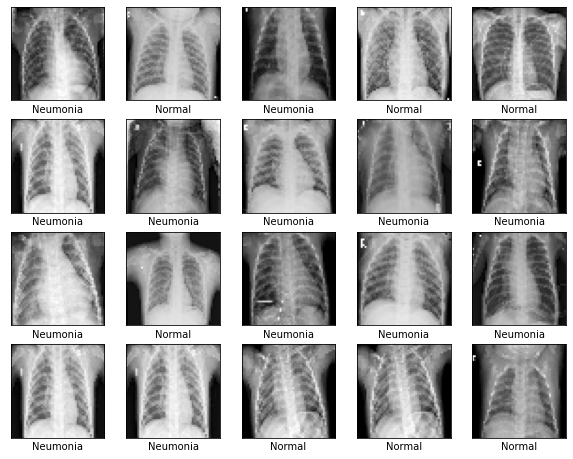

In [36]:
plt.figure(figsize=(10,10))
for i in range (20):
  j = random.randrange(5, 600, 10)
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(np.squeeze(rayos_x[j]), cmap = 'gray')
  plt.xlabel(class_names[labels[j]])
plt.show()

In [48]:
import tensorflow as tf
import tensorflow_datasets as tfds

#Crear el modelo (Modelo denso, regular, sin redes convolucionales todavia)
modelo = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(50,50,1)), #1 = blanco y negro
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(units=50, activation='relu'),
    tf.keras.layers.Dense(2, activation='softmax')
])

#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

model.fit(rayos_x, labels, epochs=30)
trained=model.fit(rayos_x, labels, epochs=30)




Epoch 1/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0901 - accuracy: 0.9728
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 0.1109 - accuracy: 0.9615
Epoch 3/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0873 - accuracy: 0.9631
Epoch 4/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0936 - accuracy: 0.9615
Epoch 5/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0913 - accuracy: 0.9679
Epoch 6/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0787 - accuracy: 0.9808
Epoch 7/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0960 - accuracy: 0.9647
Epoch 8/30
20/20 [==============================] - 0s 5ms/step - loss: 0.0829 - accuracy: 0.9712
Epoch 9/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0778 - accuracy: 0.9696
Epoch 10/30
20/20 [==============================] - 0s 4ms/step - loss: 0.0720 - accuracy: 0.9728
Epoch 11/30
20/20 [

In [37]:
import tensorflow as tf

In [38]:
from __future__ import absolute_import, division, print_function, unicode_literals

variable_name = ""
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

from __future__ import absolute_import, division, print_function, unicode_literals


# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
import tensorflow.keras.optimizers as Optimizer

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.8.0


In [39]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(50, 50, 1)),
    keras.layers.Dense(128, activation='relu'),
    
    keras.layers.Dense(2, activation='softmax'),
    
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(rayos_x, labels, epochs=30)
trained=model.fit(rayos_x, labels, epochs=30)

Epoch 1/30
20/20 [==============================] - 1s 4ms/step - loss: 1.0864 - accuracy: 0.5369
Epoch 2/30
20/20 [==============================] - 0s 5ms/step - loss: 0.5583 - accuracy: 0.7115
Epoch 3/30
20/20 [==============================] - 0s 4ms/step - loss: 0.4226 - accuracy: 0.8365
Epoch 4/30
20/20 [==============================] - 0s 4ms/step - loss: 0.3718 - accuracy: 0.8590
Epoch 5/30
20/20 [==============================] - 0s 5ms/step - loss: 0.3482 - accuracy: 0.8622
Epoch 6/30
20/20 [==============================] - 0s 4ms/step - loss: 0.3119 - accuracy: 0.8862
Epoch 7/30
20/20 [==============================] - 0s 4ms/step - loss: 0.2929 - accuracy: 0.8894
Epoch 8/30
20/20 [==============================] - 0s 5ms/step - loss: 0.3073 - accuracy: 0.8766
Epoch 9/30
20/20 [==============================] - 0s 4ms/step - loss: 0.2841 - accuracy: 0.8702
Epoch 10/30
20/20 [==============================] - 0s 5ms/step - loss: 0.2803 - accuracy: 0.8670
Epoch 11/30
20/20 [

--------------------